In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
final_sample = pd.read_csv('final_data.csv')
delivery_df = pd.read_csv('deliveries_df.csv')

In [3]:
final_sample.isna().sum()

batting_team    0
bowling_team    0
city            0
runs_left       0
balls_left      0
wickets         0
total_runs_x    0
crr             0
rrr             0
result          0
dtype: int64

In [4]:
final_sample.dtypes

batting_team     object
bowling_team     object
city             object
runs_left         int64
balls_left        int64
wickets           int64
total_runs_x      int64
crr             float64
rrr             float64
result            int64
dtype: object

Shuffling the rows of a DataFrame randomly, which can be useful for training and testing. 

In [5]:
final_sample = final_sample.sample(final_sample.shape[0])

In [6]:
final_sample.sample()

batting_team    bowling_team    city  runs_left  balls_left  wickets  \
2256  Kings XI Punjab  Mumbai Indians  Mumbai         64          40        4   

      total_runs_x   crr  rrr  result  
2256           174  8.25  9.6       0

In [7]:
final_sample.dropna(inplace=True)

Removing rows where the 'balls_left' value is zero, because we need to consider matches where both teams had a chance to complete their innings.

In [8]:
final_sample = final_sample[final_sample['balls_left'] != 0]

Creating the two variables X and y by splittng final_sample into two parts. 
X contains all rows and columns except the last column, and y contains all rows and only the last column. 

In [9]:
X = final_sample.drop(columns=final_sample.columns[-1])

y = final_sample.iloc[:, -1]

 Lets split the X and y data into separate training and test sets.

In [10]:
from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)



# 20% of the data will be used for testing, while the remaining 80% will be used for training.

In [11]:
X_train.to_csv('X_train.csv', index=False)

In [12]:
X_train.head(4)

batting_team                 bowling_team       city  \
36181       Delhi Daredevils              Kings XI Punjab       Pune   
16095        Kings XI Punjab  Royal Challengers Bangalore  Bangalore   
69195  Kolkata Knight Riders  Royal Challengers Bangalore  Bangalore   
32030    Sunrisers Hyderabad               Mumbai Indians  Hyderabad   

       runs_left  balls_left  wickets  total_runs_x        crr       rrr  
36181        117          81        9           165   7.384615  8.666667  
16095         39          40        8           158   8.925000  5.850000  
69195          2          36        7           158  11.142857  0.333333  
32030         70          62        8           129   6.103448  6.774194

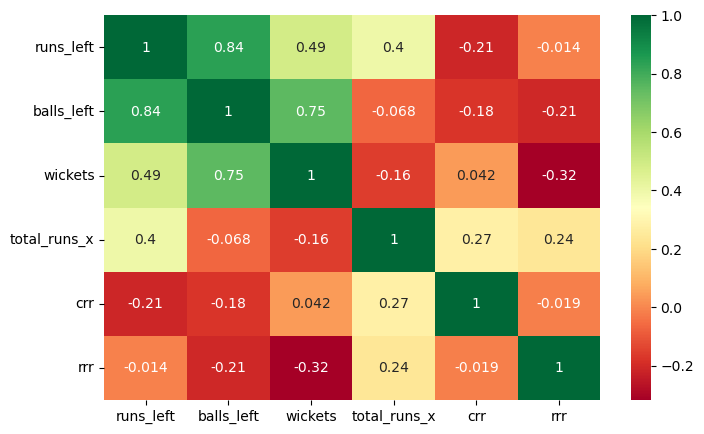

In [13]:
Selected_features = ['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']
X = X_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

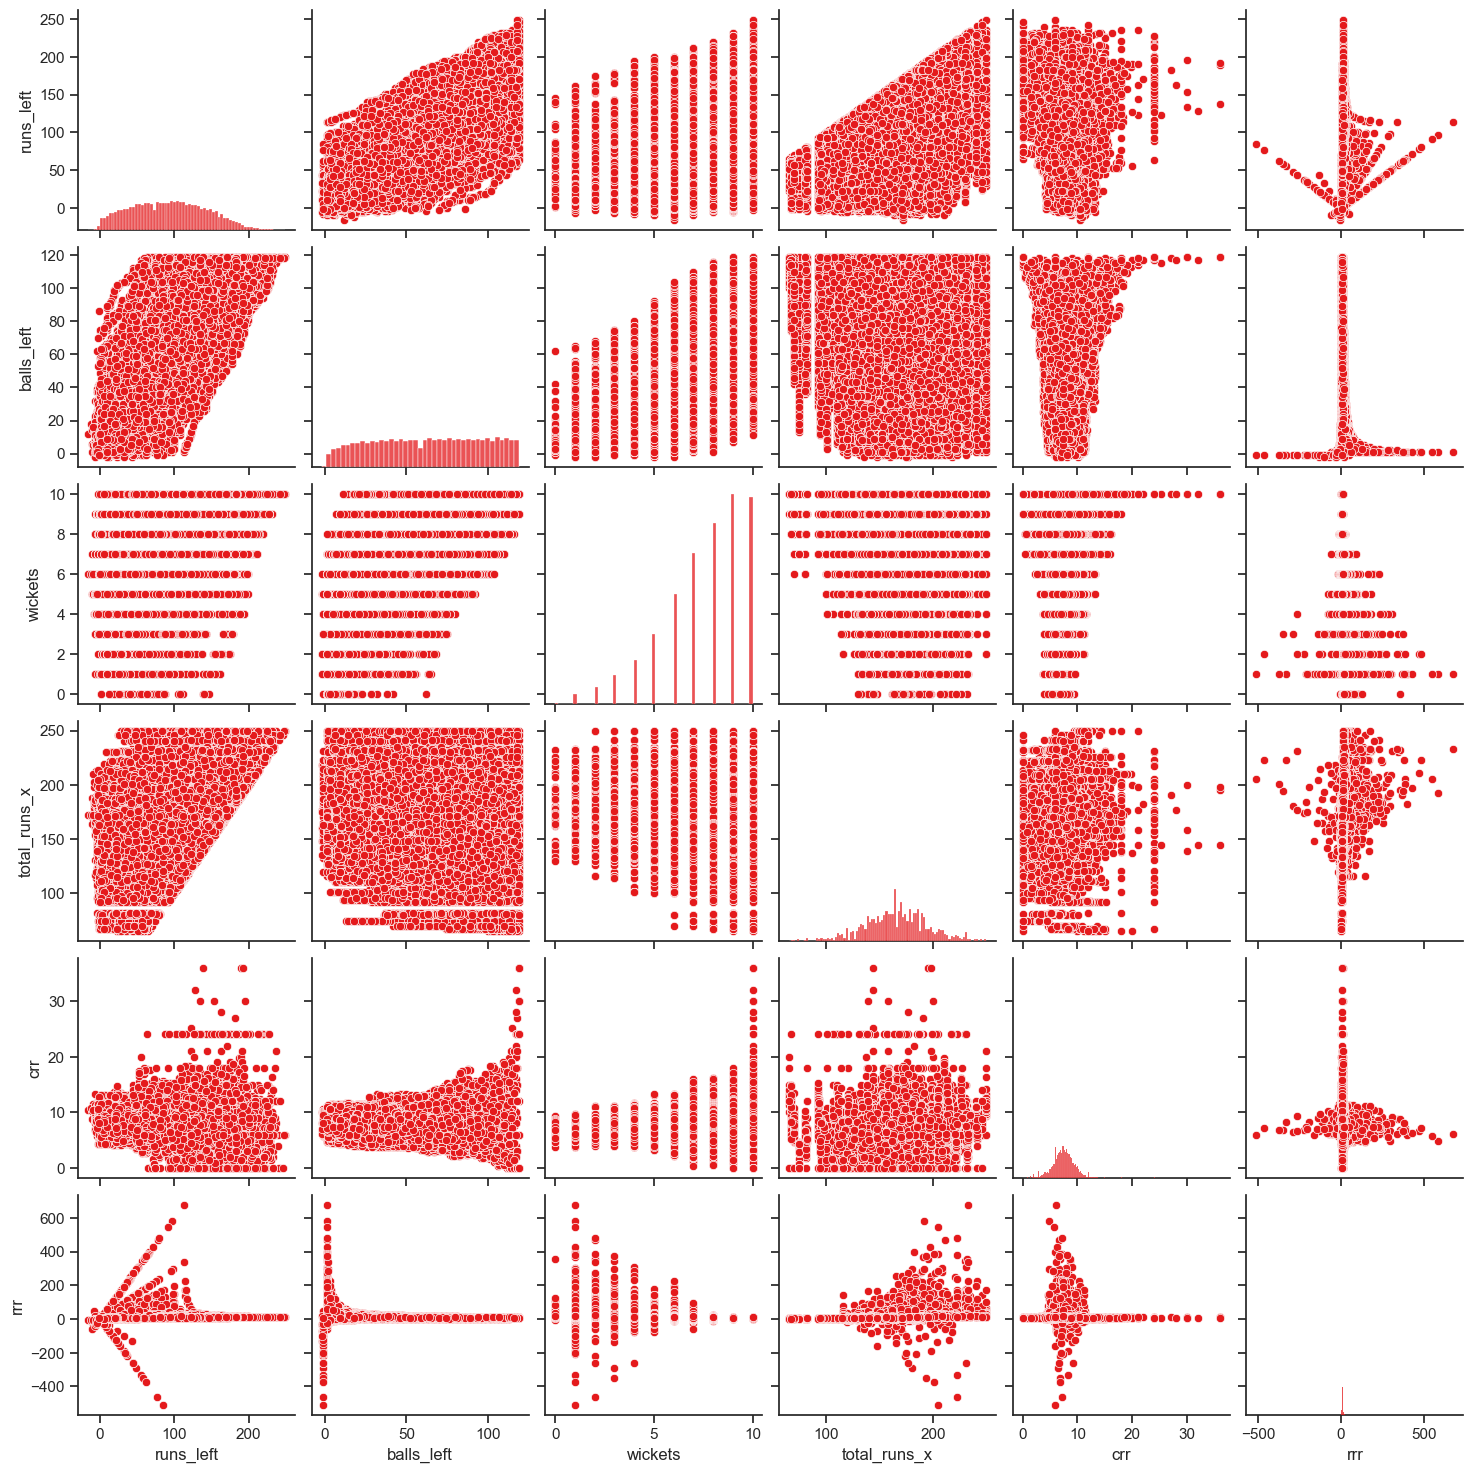

In [14]:
sns.set(style='ticks', palette='Set1')
sns.pairplot(X_train)
plt.show()

Using it to apply a one-hot encoding transformation to the categorical features batting team, bowling team, and city. Numerical features will pass through unchanged with the "Remainder Passthrough Parameter". 

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])]
                        ,remainder='passthrough')

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [17]:
gbm = Pipeline(steps=[('step1', trf),('step2', GradientBoostingClassifier())])

In [18]:
X_train

batting_team                 bowling_team         city  \
36181       Delhi Daredevils              Kings XI Punjab         Pune   
16095        Kings XI Punjab  Royal Challengers Bangalore    Bangalore   
69195  Kolkata Knight Riders  Royal Challengers Bangalore    Bangalore   
32030    Sunrisers Hyderabad               Mumbai Indians    Hyderabad   
2310        Delhi Daredevils          Chennai Super Kings         Pune   
...                      ...                          ...          ...   
66788  Kolkata Knight Riders               Mumbai Indians  East London   
20155        Deccan Chargers               Mumbai Indians    Hyderabad   
36089       Rajasthan Royals               Mumbai Indians       Jaipur   
41690  Kolkata Knight Riders  Royal Challengers Bangalore    Bangalore   
2969     Sunrisers Hyderabad          Chennai Super Kings      Chennai   

       runs_left  balls_left  wickets  total_runs_x        crr        rrr  
36181        117          81        9           165   7.384615   8.666667  
16095         39          40        8           158   8.925000   5.850000  
69195          2          36        7           158  11.142857   0.333333  
32030         70          62        8           129   6.103448   6.774194  
2310         157          83        8           218   9.891892  11.349398  
...          ...         ...      ...           ...        ...        ...  
66788        147         116        9           148   1.500000   7.603448  
20155        122          64        6           178   6.000000  11.437500  
36089         20          18        7           171   8.882353   6.666667  
41690         81          36        6           185   7.428571  13.500000  
2969         109          39        7           209   7.407407  16.769231  

[57073 rows x 9 columns]

In [19]:
gbm.fit(X_train,y_train)

C:\Users\deepe\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', GradientBoostingClassifier())])

In [20]:
y_pred = gbm.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.841895017170089

In [22]:
gbm.predict_proba(X_test)[7]

array([0.03386973, 0.96613027])

In [23]:
def match_ipl(df, match_id, gbm):
    
    # Filter the delivery data to get all rows for the specified match_id
    
    match = df[df['match_id'] == match_id]
    
    # Only keep rows where the ball is the last ball of the over
    
    match = match[(match['ball'] == 6)]
    
    # Create a temporary dataframe with relevant columns
    
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    
    # Remove rows where there are no balls left to play
    
    temp_df = temp_df[temp_df['balls_left'] != 0]
    
    # Make predictions for each row using the provided gradient boosting model
    
    result = gbm.predict_proba(temp_df)
    
    # Add columns for predicted probabilities of winning or losing
    
    temp_df['Lose'] = np.round(result.T[0]*100,1)
    
    temp_df['Win'] = np.round(result.T[1]*100,1)
    
    # Add column for end of over, which is just a sequential count of rows
    
    temp_df['End_of_Over'] = range(1,temp_df.shape[0]+1)
    
    # Calculate target score and runs and wickets remaining for each over
    
    target = temp_df['total_runs_x'].values[0]
    
    runs = list(temp_df['runs_left'].values)
    
    new_runs = runs[:]
    
    runs.insert(0,target)
    
    temp_df['Runs_after_Over'] = np.array(runs)[:-1] - np.array(new_runs)
    
    wickets = list(temp_df['wickets'].values)
    
    new_wickets = wickets[:]
    
    new_wickets.insert(0,10)
    
    wickets.append(0)
    
    w = np.array(wickets)
    
    nw = np.array(new_wickets)
    
    temp_df['Wickets_in_Over'] = (nw - w)[0:temp_df.shape[0]]
    
    # Print target score for the match
    
    print("Target-",target)
    
    # Only keep relevant columns in the final output
    
    temp_df = temp_df[['End_of_Over','Runs_after_Over','Wickets_in_Over','Lose','Win']]
    
    return temp_df, target

In [24]:
gbm_temp_df, gbm_target = match_ipl(delivery_df, 234, gbm)
gbm_temp_df

Target- 168


End_of_Over  Runs_after_Over  Wickets_in_Over  Lose   Win
2098            1                0                0  45.7  54.3
2104            2                3                1  52.2  47.8
2110            3                5                0  52.2  47.8
2117            4                3                0  61.7  38.3
2123            5               10                0  56.7  43.3
2129            6               11                0  54.4  45.6
2136            7                6                0  53.5  46.5
2142            8                2                0  57.7  42.3
2148            9                3                0  64.1  35.9
2154           10               15                0  55.8  44.2
2160           11                9                0  57.3  42.7
2166           12                6                2  72.8  27.2
2172           13                7                0  74.6  25.4
2178           14               13                0  70.0  30.0
2186           15                8                2  86.3  13.7
2192           16                6                0  90.5   9.5
2199           17                7                1  94.1   5.9
2205           18               22                0  84.0  16.0
2211           19                6                2  92.4   7.6

In [ ]:
# import pickle
# pickle.dump(gbm,open('gbm.pkl','wb'))